## Import library

In [1]:
import lightgbm as lgb

from sklearn import datasets
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import itertools

import numpy as np
import pandas as pd
import cython
import multiprocessing as mp
from multiprocessing import Pool
from functools import partial
import gc

from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold

import glob
from sklearn.preprocessing import StandardScaler

%load_ext Cython

In [2]:
def multi_weighted_logloss(y_ohe, y_p):
    """
    @author olivier https://www.kaggle.com/ogrellier
    multi logloss for PLAsTiCC challenge
    """
    classes = [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]
    class_weight = {6: 1, 15: 2, 16: 1, 42: 1, 52: 1, 53: 1, 62: 1, 64: 2, 65: 1, 67: 1, 88: 1, 90: 1, 92: 1, 95: 1}
    # Normalize rows and limit y_preds to 1e-15, 1-1e-15
    y_p = np.clip(a=y_p, a_min=1e-15, a_max=1-1e-15)
    # Transform to log
    y_p_log = np.log(y_p)
    # Get the log for ones, .values is used to drop the index of DataFrames
    # Exclude class 99 for now, since there is no class99 in the training set 
    # we gave a special process for that class
    y_log_ones = np.sum(y_ohe * y_p_log, axis=0)
    # Get the number of positives for each class
    nb_pos = y_ohe.sum(axis=0).astype(float)
    # Weight average and divide by the number of positives
    class_arr = np.array([class_weight[k] for k in sorted(class_weight.keys())])
    y_w = y_log_ones * class_arr / nb_pos    
    loss = - np.sum(y_w) / np.sum(class_arr)
    return loss

In [14]:
def lgb_multi_weighted_logloss(y_true, y_preds):
    """
    @author olivier https://www.kaggle.com/ogrellier
    multi logloss for PLAsTiCC challenge
    """
    # class_weights taken from Giba's topic : https://www.kaggle.com/titericz
    # https://www.kaggle.com/c/PLAsTiCC-2018/discussion/67194
    # with Kyle Boone's post https://www.kaggle.com/kyleboone
    classes = [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]
    class_weight = {6: 1, 15: 2, 16: 1, 42: 1, 52: 1, 53: 1, 62: 1, 64: 2, 65: 1, 67: 1, 88: 1, 90: 1, 92: 1, 95: 1}
    if len(np.unique(y_true)) > 14:
        classes.append(99)
        class_weight[99] = 2
    y_p = y_preds.reshape(y_true.shape[0], len(classes), order='F')

    # Trasform y_true in dummies
    y_ohe = pd.get_dummies(y_true)
    # Normalize rows and limit y_preds to 1e-15, 1-1e-15
    y_p = np.clip(a=y_p, a_min=1e-15, a_max=1 - 1e-15)
    # Transform to log
    y_p_log = np.log(y_p)
    # Get the log for ones, .values is used to drop the index of DataFrames
    # Exclude class 99 for now, since there is no class99 in the training set
    # we gave a special process for that class
    y_log_ones = np.sum(y_ohe.values * y_p_log, axis=0)
    # Get the number of positives for each class
    nb_pos = y_ohe.sum(axis=0).values.astype(float)
    # Weight average and divide by the number of positives
    class_arr = np.array([class_weight[k] for k in sorted(class_weight.keys())])
    y_w = y_log_ones * class_arr / nb_pos

    loss = - np.sum(y_w) / np.sum(class_arr)
    return 'wloss', loss, False

In [15]:
def plot_loss_acc(history):
    plt.plot(history.history['loss'][1:])
    plt.plot(history.history['val_loss'][1:])
    plt.title('model loss')
    plt.ylabel('val_loss')
    plt.xlabel('epoch')
    plt.legend(['train','Validation'], loc='upper left')
    plt.show()
    
    plt.plot(history.history['acc'][1:])
    plt.plot(history.history['val_acc'][1:])
    plt.title('model Accuracy')
    plt.ylabel('val_acc')
    plt.xlabel('epoch')
    plt.legend(['train','Validation'], loc='upper left')
    plt.show()

## Data import

In [16]:
train = pd.read_pickle('../input/train_ex_gal_20181214.pickle')
test = pd.read_pickle('../input/test_ex_gal_20181214.pickle')

In [17]:
train_oof = pd.read_pickle('../input/oof_result_20181216_v2.pickle') # Best:1216(0.947)
test_oof = pd.read_pickle('../input/preds_result_20181216_v2.pickle') # Best:1226(0.947)

In [18]:
train_length = pd.read_pickle('../input/train_length.pickle')
test_length = pd.read_pickle('../input/test_length.pickle')

train_band_length = pd.read_pickle('../input/train_band_length.pickle')
test_band_length = pd.read_pickle('../input/test_band_length.pickle')

train_sixth_band = pd.read_pickle('../input/train_sixth_byband.pickle')
test_sixth_band = pd.read_pickle('../input/test_sixth_byband.pickle')

train_fix_band_0_stats = pd.read_pickle('../input/train_band_0_fix_stats.pickle')
test_fix_band_0_stats = pd.read_pickle('../input/test_band_0_fix_stats.pickle')

train_fix_band_1_stats = pd.read_pickle('../input/train_band_1_fix_stats.pickle')
test_fix_band_1_stats = pd.read_pickle('../input/test_band_1_fix_stats.pickle')

In [19]:
train = pd.merge(train,train_oof,on='object_id',how='left')
train = pd.merge(train,train_length,on='object_id',how='left')
train = pd.merge(train,train_band_length,on='object_id',how='left')
train = pd.merge(train,train_sixth_band,on='object_id',how='left')
train = pd.merge(train,train_fix_band_0_stats,on='object_id',how='left')
train = pd.merge(train,train_fix_band_1_stats,on='object_id',how='left')

In [20]:
test = pd.merge(test,test_oof,on='object_id',how='left')
test = pd.merge(test,test_length,on='object_id',how='left')
test = pd.merge(test,test_band_length,on='object_id',how='left')
test = pd.merge(test,test_sixth_band,on='object_id',how='left')
test = pd.merge(test,test_fix_band_0_stats,on='object_id',how='left')
test = pd.merge(test,test_fix_band_1_stats,on='object_id',how='left')

In [21]:
train['flux__longest_strike_above_mean'] = train['flux__longest_strike_above_mean'] / train['count']
train['flux__number_crossing_m__m_1'] = train['flux__number_crossing_m__m_1'] / train['count']

train['0__longest_strike_above_mean'] = train['0__longest_strike_above_mean'] / train['passband_count_0']
train['1__longest_strike_above_mean'] = train['1__longest_strike_above_mean'] / train['passband_count_1']
train['2__longest_strike_above_mean'] = train['2__longest_strike_above_mean'] / train['passband_count_2']
train['3__longest_strike_above_mean'] = train['3__longest_strike_above_mean'] / train['passband_count_3']
train['4__longest_strike_above_mean'] = train['4__longest_strike_above_mean'] / train['passband_count_4']
train['5__longest_strike_above_mean'] = train['5__longest_strike_above_mean'] / train['passband_count_5']

train['0__number_crossing_m__m_1'] = train['0__number_crossing_m__m_1'] / train['passband_count_0']
train['1__number_crossing_m__m_1'] = train['1__number_crossing_m__m_1'] / train['passband_count_1']
train['2__number_crossing_m__m_1'] = train['2__number_crossing_m__m_1'] / train['passband_count_2']
train['3__number_crossing_m__m_1'] = train['3__number_crossing_m__m_1'] / train['passband_count_3']
train['4__number_crossing_m__m_1'] = train['4__number_crossing_m__m_1'] / train['passband_count_4']
train['5__number_crossing_m__m_1'] = train['5__number_crossing_m__m_1'] / train['passband_count_5']

In [22]:
test['flux__longest_strike_above_mean'] = test['flux__longest_strike_above_mean'] / test['count']
test['flux__number_crossing_m__m_1'] = test['flux__number_crossing_m__m_1'] / test['count']

test['0__longest_strike_above_mean'] = test['0__longest_strike_above_mean'] / test['passband_count_0']
test['1__longest_strike_above_mean'] = test['1__longest_strike_above_mean'] / test['passband_count_1']
test['2__longest_strike_above_mean'] = test['2__longest_strike_above_mean'] / test['passband_count_2']
test['3__longest_strike_above_mean'] = test['3__longest_strike_above_mean'] / test['passband_count_3']
test['4__longest_strike_above_mean'] = test['4__longest_strike_above_mean'] / test['passband_count_4']
test['5__longest_strike_above_mean'] = test['5__longest_strike_above_mean'] / test['passband_count_5']

test['0__number_crossing_m__m_1'] = test['0__number_crossing_m__m_1'] / test['passband_count_0']
test['1__number_crossing_m__m_1'] = test['1__number_crossing_m__m_1'] / test['passband_count_1']
test['2__number_crossing_m__m_1'] = test['2__number_crossing_m__m_1'] / test['passband_count_2']
test['3__number_crossing_m__m_1'] = test['3__number_crossing_m__m_1'] / test['passband_count_3']
test['4__number_crossing_m__m_1'] = test['4__number_crossing_m__m_1'] / test['passband_count_4']
test['5__number_crossing_m__m_1'] = test['5__number_crossing_m__m_1'] / test['passband_count_5']

In [23]:
drop_list = ['passband_count_0','passband_count_1','passband_count_2','passband_count_3','passband_count_4','passband_count_5'
             ,'count','count_det','flux_dif','index','flux_mean','flux_mean_detected'
             ,'0__minimum_diff','1__minimum_diff','2__minimum_diff','3__minimum_diff','4__minimum_diff','5__minimum_diff'
             ,'diff_flux__minimum_diff','diff_flux__minimum_diff_det']

In [24]:
train = train.drop(drop_list, axis=1)
test = test.drop(drop_list, axis=1)

In [25]:
# add mean → good result

train = train.replace([np.inf, -np.inf], np.nan)
test = test.replace([np.inf, -np.inf], np.nan)

train_mean = train.mean(axis=0)
train.fillna(train_mean, inplace=True)
test = test.fillna(train_mean)

In [26]:
train.head(3)

,object_id,gal_b,hostgal_photoz,hostgal_photoz_err,target,haversine,latlon1,diff_hostgal,diff_hostgal_abs,passband_0_ratio_detect,...,band_0_flux_mean,band_0_flux_med,band_0_flux_skew,band_0_flux_std,band_1_flux_max,band_1_flux_min,band_1_flux_mean,band_1_flux_med,band_1_flux_skew,band_1_flux_std
0,615,-51.753706,0.0000,0.0000,92,0.319006,-1.528827,0.0000,0.0000,0.162162,...,-3.254554e+00,-1.001523e+01,0.128917,8.394473e+01,6.606263e+02,-1.100440e+03,-2.599232e+02,-3.492156e+02,0.185580,5.460072e+02
1,713,-54.460748,1.6267,0.2552,88,1.698939,3.258921,0.1914,0.1914,0.166667,...,-6.850926e+08,-9.404832e+08,0.218182,2.708821e+09,9.436742e+08,-2.638417e+08,1.043975e+08,2.613925e+07,1.783298,3.162242e+08
2,730,-61.548219,0.2262,0.0157,42,1.818030,3.128522,0.0058,0.0058,0.000000,...,2.190031e+05,2.660137e+05,0.471342,2.805885e+06,3.259617e+07,-4.423077e+06,3.727567e+06,7.635489e+05,2.385066,8.631597e+06


In [27]:
import sys
# check used_momery
print(train.shape,"行×列")
print("train:使用メモリ",round(sys.getsizeof(train) / 1073741824,2),"GB")

print(test.shape,"行×列")
print("test:使用メモリ",round(sys.getsizeof(test) / 1073741824,2),"GB")

(7848, 223) 行×列
train:使用メモリ 0.01 GB
(3492890, 222) 行×列
test:使用メモリ 5.26 GB


## modeling NN

In [28]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

In [29]:
from keras.models import Sequential
from keras.layers import Dense,BatchNormalization,Dropout
from keras.callbacks import ReduceLROnPlateau,ModelCheckpoint, EarlyStopping  
from keras.utils import to_categorical
import tensorflow as tf
from keras import backend as K
import keras
from keras import regularizers
from collections import Counter
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


In [30]:
if 'target' in train:
    y = train['target']
    del train['target']

del train['object_id'],test['object_id']
classes = sorted(y.unique())


# Taken from Giba's topic : https://www.kaggle.com/titericz
# https://www.kaggle.com/c/PLAsTiCC-2018/discussion/67194
# with Kyle Boone's post https://www.kaggle.com/kyleboone
class_weight = {
    c: 1 for c in classes
}
for c in [64, 15]:
    class_weight[c] = 2

In [31]:
#train_new = train.copy()

len_train = len(train)
merge = train.append(test)

ss = StandardScaler()
merge_ss = ss.fit_transform(merge)
train_ss = merge_ss[:len_train]
test_ss = merge_ss[len_train:]

In [32]:
print(train.shape)
print(test.shape)

(7848, 221)
(3492890, 221)


In [33]:
# https://www.kaggle.com/c/PLAsTiCC-2018/discussion/69795
def mywloss(y_true,y_pred):  
    yc=tf.clip_by_value(y_pred,1e-15,1-1e-15)
    loss=-(tf.reduce_mean(tf.reduce_mean(y_true*tf.log(yc),axis=0)/wtable))
    return loss

In [34]:
from keras.layers import PReLU, ReLU, Activation

In [35]:
K.clear_session()
def build_model(dropout_rate=0.25, activation='relu'):
    start_neurons = 256
    # create model
    model = Sequential()
    
    model.add(Dense(start_neurons, input_dim=train_ss.shape[1], activation=None))
    model.add(BatchNormalization())
    model.add(Activation(activation))
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(start_neurons//2,activation=None))
    model.add(BatchNormalization())
    model.add(Activation(activation))
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(start_neurons//4,activation=None))
    model.add(BatchNormalization())
    model.add(Activation(activation))
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(start_neurons//8,activation=None))
    model.add(BatchNormalization())
    model.add(Activation(activation))
    model.add(Dropout(dropout_rate/2))
    
    model.add(Dense(len(classes), activation='softmax'))
    
    return model

In [36]:
unique_y = np.unique(y)
class_map = dict()
for i,val in enumerate(unique_y):
    class_map[val] = i
        
y_map = np.zeros((y.shape[0],))
y_map = np.array([class_map[val] for val in y])
y_categorical = to_categorical(y_map)

In [37]:
y_count = Counter(y_map)
wtable = np.zeros((len(unique_y),))
for i in range(len(unique_y)):
    wtable[i] = y_count[i]/y_map.shape[0]

Train on 6274 samples, validate on 1574 samples
Epoch 1/200
6274/6274 [==============================] - 4s 571us/step - loss: 1.6201 - acc: 0.4402 - val_loss: 0.8891 - val_acc: 0.6366

Epoch 00001: val_loss improved from inf to 0.88906, saving model to model_fold_0.model
Epoch 2/200
6274/6274 [==============================] - 1s 88us/step - loss: 0.9763 - acc: 0.6436 - val_loss: 0.6931 - val_acc: 0.7573

Epoch 00002: val_loss improved from 0.88906 to 0.69306, saving model to model_fold_0.model
Epoch 3/200
6274/6274 [==============================] - 0s 67us/step - loss: 0.7855 - acc: 0.7225 - val_loss: 0.6117 - val_acc: 0.7719

Epoch 00003: val_loss improved from 0.69306 to 0.61165, saving model to model_fold_0.model
Epoch 4/200
6274/6274 [==============================] - 0s 77us/step - loss: 0.6761 - acc: 0.7383 - val_loss: 0.5892 - val_acc: 0.7459

Epoch 00004: val_loss improved from 0.61165 to 0.58916, saving model to model_fold_0.model
Epoch 5/200
6274/6274 [====================

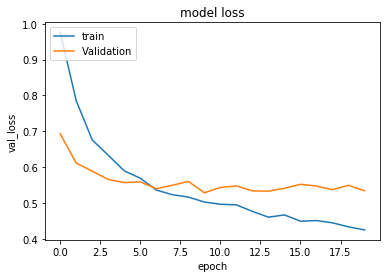

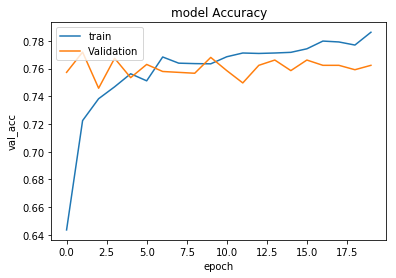

Loading Best Model
0.5268328867662269
Train on 6276 samples, validate on 1572 samples
Epoch 1/200
6276/6276 [==============================] - 2s 305us/step - loss: 1.6657 - acc: 0.3754 - val_loss: 0.8899 - val_acc: 0.6291

Epoch 00001: val_loss improved from inf to 0.88987, saving model to model_fold_1.model
Epoch 2/200
6276/6276 [==============================] - 0s 74us/step - loss: 0.9975 - acc: 0.6017 - val_loss: 0.7259 - val_acc: 0.7169

Epoch 00002: val_loss improved from 0.88987 to 0.72592, saving model to model_fold_1.model
Epoch 3/200
6276/6276 [==============================] - 1s 83us/step - loss: 0.8068 - acc: 0.6893 - val_loss: 0.6381 - val_acc: 0.7532

Epoch 00003: val_loss improved from 0.72592 to 0.63810, saving model to model_fold_1.model
Epoch 4/200
6276/6276 [==============================] - 0s 70us/step - loss: 0.6963 - acc: 0.7310 - val_loss: 0.6150 - val_acc: 0.7615

Epoch 00004: val_loss improved from 0.63810 to 0.61504, saving model to model_fold_1.model
Epoch

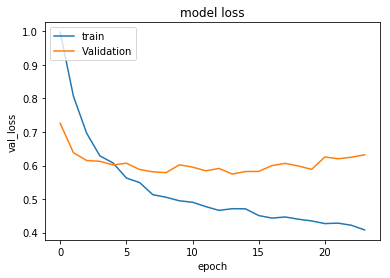

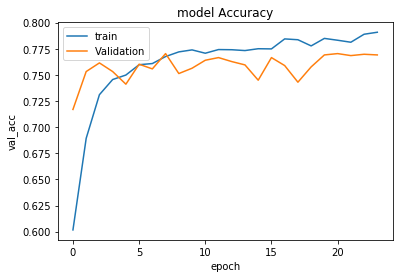

Loading Best Model
0.5597799874823239
Train on 6277 samples, validate on 1571 samples
Epoch 1/200
6277/6277 [==============================] - 1s 222us/step - loss: 1.6159 - acc: 0.4400 - val_loss: 0.8687 - val_acc: 0.7015

Epoch 00001: val_loss improved from inf to 0.86870, saving model to model_fold_2.model
Epoch 2/200
6277/6277 [==============================] - 0s 68us/step - loss: 0.9767 - acc: 0.6444 - val_loss: 0.6997 - val_acc: 0.7422

Epoch 00002: val_loss improved from 0.86870 to 0.69973, saving model to model_fold_2.model
Epoch 3/200
6277/6277 [==============================] - 0s 64us/step - loss: 0.7985 - acc: 0.7102 - val_loss: 0.6327 - val_acc: 0.7479

Epoch 00003: val_loss improved from 0.69973 to 0.63274, saving model to model_fold_2.model
Epoch 4/200
6277/6277 [==============================] - 0s 63us/step - loss: 0.6943 - acc: 0.7375 - val_loss: 0.6082 - val_acc: 0.7600

Epoch 00004: val_loss improved from 0.63274 to 0.60817, saving model to model_fold_2.model
Epoch

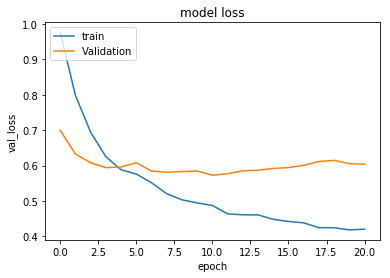

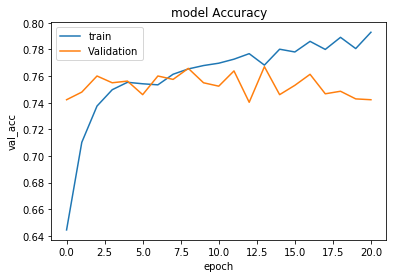

Loading Best Model
0.5783115574043947
Train on 6281 samples, validate on 1567 samples
Epoch 1/200
6281/6281 [==============================] - 1s 234us/step - loss: 1.7267 - acc: 0.4270 - val_loss: 0.9359 - val_acc: 0.6886

Epoch 00001: val_loss improved from inf to 0.93593, saving model to model_fold_3.model
Epoch 2/200
6281/6281 [==============================] - 1s 85us/step - loss: 1.0216 - acc: 0.6432 - val_loss: 0.7018 - val_acc: 0.7435

Epoch 00002: val_loss improved from 0.93593 to 0.70182, saving model to model_fold_3.model
Epoch 3/200
6281/6281 [==============================] - 0s 68us/step - loss: 0.7910 - acc: 0.7123 - val_loss: 0.6163 - val_acc: 0.7728

Epoch 00003: val_loss improved from 0.70182 to 0.61626, saving model to model_fold_3.model
Epoch 4/200
6281/6281 [==============================] - 0s 78us/step - loss: 0.6843 - acc: 0.7419 - val_loss: 0.5979 - val_acc: 0.7792

Epoch 00004: val_loss improved from 0.61626 to 0.59787, saving model to model_fold_3.model
Epoch

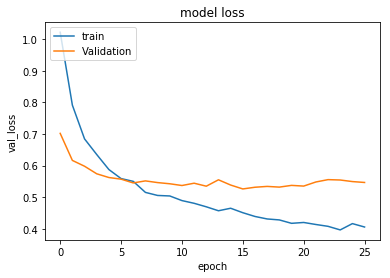

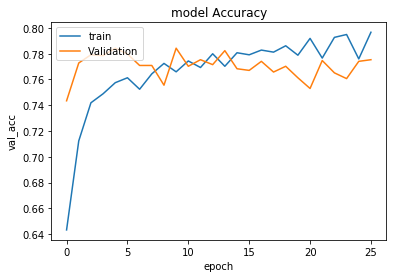

Loading Best Model
0.5149047833247211
Train on 6284 samples, validate on 1564 samples
Epoch 1/200
6284/6284 [==============================] - 2s 255us/step - loss: 1.7395 - acc: 0.4260 - val_loss: 0.9544 - val_acc: 0.6931

Epoch 00001: val_loss improved from inf to 0.95445, saving model to model_fold_4.model
Epoch 2/200
6284/6284 [==============================] - 1s 86us/step - loss: 1.0197 - acc: 0.6502 - val_loss: 0.7394 - val_acc: 0.7142

Epoch 00002: val_loss improved from 0.95445 to 0.73936, saving model to model_fold_4.model
Epoch 3/200
6284/6284 [==============================] - 0s 79us/step - loss: 0.8074 - acc: 0.7105 - val_loss: 0.6851 - val_acc: 0.7628

Epoch 00003: val_loss improved from 0.73936 to 0.68510, saving model to model_fold_4.model
Epoch 4/200
6284/6284 [==============================] - 1s 85us/step - loss: 0.7197 - acc: 0.7293 - val_loss: 0.6338 - val_acc: 0.7583

Epoch 00004: val_loss improved from 0.68510 to 0.63378, saving model to model_fold_4.model
Epoch

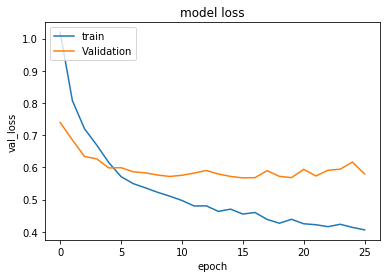

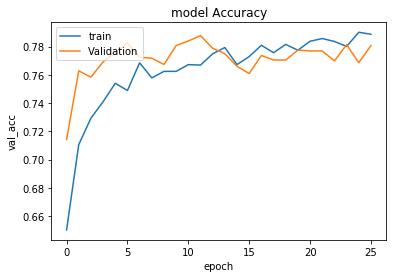

Loading Best Model
0.5675069262478121
MULTI WEIGHTED LOG LOSS : 0.54945 


In [38]:
clfs = []
oof_preds = np.zeros((len(train_ss), len(classes)))
epochs = 200
batch_size = 100

for fold_, (trn_, val_) in enumerate(folds.split(y_map, y_map)):
    model_name = 'model_fold_%s.model' % (fold_)
    x_train, y_train = train_ss[trn_], y_categorical[trn_]
    x_valid, y_valid = train_ss[val_], y_categorical[val_]
    K.clear_session()
    model = build_model(dropout_rate=0.25, activation='tanh')    
    model.compile(loss=mywloss, optimizer='adam', metrics=['accuracy'])
    
    early_stopping = EarlyStopping(patience=10, verbose=1)
    checkPoint = ModelCheckpoint(model_name,monitor='val_loss',mode = 'min', save_best_only=True, verbose=10)
    
    history = model.fit(x_train, y_train,
                    validation_data=[x_valid, y_valid], 
                    epochs=epochs,
                    batch_size=batch_size,shuffle=True,verbose=1,
                    callbacks=[checkPoint,early_stopping])       
    
    plot_loss_acc(history)

    print('Loading Best Model')
    model.load_weights(model_name)
    # # Get predicted probabilities for each class
    oof_preds[val_, :] = model.predict_proba(x_valid,batch_size=batch_size)
    print(multi_weighted_logloss(y_valid, model.predict_proba(x_valid,batch_size=batch_size)))
    clfs.append(model)
    
print('MULTI WEIGHTED LOG LOSS : %.5f ' % multi_weighted_logloss(y_categorical,oof_preds))

In [39]:
# http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [40]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_map, np.argmax(oof_preds,axis=-1))
np.set_printoptions(precision=2)

In [41]:
sample_sub = pd.read_csv('../input/sample_submission.csv')
class_names = list(sample_sub.columns[1:-1])
del sample_sub;gc.collect()

23279

Normalized confusion matrix
[[9.27e-01 0.00e+00 6.62e-03 0.00e+00 0.00e+00 6.62e-03 0.00e+00 0.00e+00
  5.96e-02 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00]
 [0.00e+00 7.76e-01 0.00e+00 6.46e-02 3.64e-02 0.00e+00 2.22e-02 2.02e-03
  0.00e+00 2.42e-02 2.02e-03 6.06e-02 0.00e+00 1.21e-02]
 [0.00e+00 1.08e-03 9.87e-01 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
  3.25e-03 0.00e+00 1.08e-03 0.00e+00 6.49e-03 1.08e-03]
 [8.38e-04 9.22e-02 0.00e+00 4.73e-01 1.14e-01 0.00e+00 1.35e-01 1.51e-02
  0.00e+00 5.28e-02 0.00e+00 1.03e-01 0.00e+00 1.42e-02]
 [0.00e+00 2.73e-02 0.00e+00 1.20e-01 4.81e-01 0.00e+00 6.56e-02 0.00e+00
  0.00e+00 7.10e-02 0.00e+00 2.35e-01 0.00e+00 0.00e+00]
 [0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 1.00e+00 0.00e+00 0.00e+00
  0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00]
 [0.00e+00 3.51e-02 0.00e+00 1.53e-01 8.06e-02 0.00e+00 5.00e-01 2.48e-02
  0.00e+00 1.45e-01 0.00e+00 5.99e-02 0.00e+00 2.07e-03]
 [0.00e+00 1.96e-02 0.00e+00 2.94e-02 0.00e+00 0.00e+00

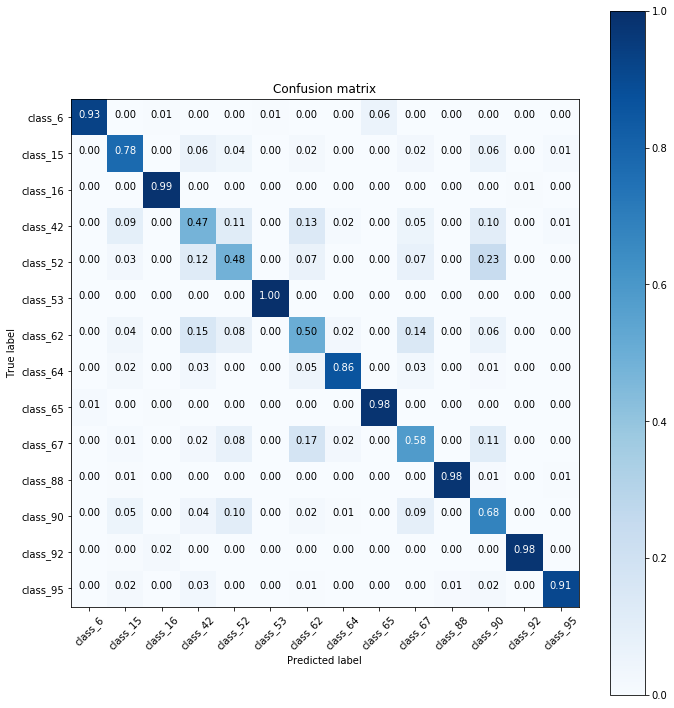

In [33]:
# no_oof_preds
plt.figure(figsize=(10,10))
foo = plot_confusion_matrix(cnf_matrix, classes=class_names,normalize=True,
                      title='Confusion matrix')

Normalized confusion matrix
[[0.92 0.   0.01 0.   0.   0.03 0.   0.   0.05 0.   0.   0.   0.   0.  ]
 [0.   0.78 0.   0.06 0.03 0.   0.04 0.   0.   0.03 0.   0.05 0.   0.01]
 [0.   0.   0.98 0.   0.   0.   0.   0.   0.01 0.   0.   0.   0.01 0.  ]
 [0.   0.09 0.   0.44 0.12 0.   0.15 0.02 0.   0.06 0.   0.11 0.   0.02]
 [0.   0.04 0.   0.11 0.46 0.   0.08 0.01 0.   0.05 0.   0.25 0.   0.  ]
 [0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.03 0.   0.15 0.08 0.   0.49 0.02 0.   0.17 0.   0.05 0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.02 0.94 0.   0.04 0.   0.   0.   0.  ]
 [0.01 0.   0.   0.   0.   0.   0.   0.   0.98 0.   0.   0.   0.   0.  ]
 [0.   0.01 0.   0.02 0.08 0.   0.17 0.02 0.   0.59 0.   0.1  0.   0.  ]
 [0.   0.01 0.   0.   0.   0.   0.   0.   0.   0.   0.97 0.01 0.   0.01]
 [0.   0.05 0.   0.04 0.11 0.   0.02 0.01 0.   0.09 0.   0.67 0.   0.  ]
 [0.   0.   0.02 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.97 0.  ]
 [0.   0.02 0.   0.02 0

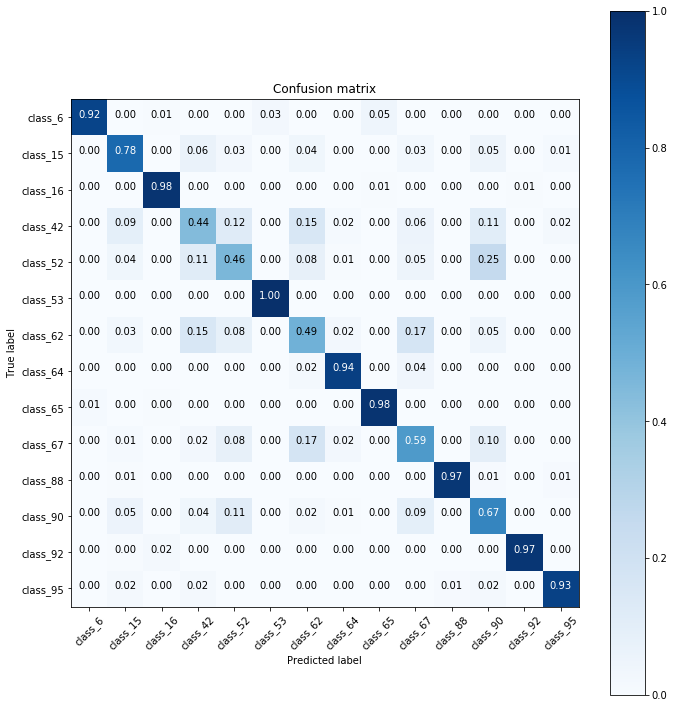

In [138]:
# Plot non-normalized confusion matrix
plt.figure(figsize=(10,10))
foo = plot_confusion_matrix(cnf_matrix, classes=class_names,normalize=True,
                      title='Confusion matrix')

In [93]:
#test_feature = test[train.columns]

## prediction

In [30]:
#ss = StandardScaler()
#test_ss = ss.fit_transform(test[train.columns])

In [100]:
test.shape

(3492890, 195)

In [42]:
from tqdm import tqdm_notebook
# pred
#test_ss = ss.transform(test[train.columns])
# Make predictions
preds = None
for clf in tqdm_notebook(clfs):
    if preds is None:
        preds = clf.predict_proba(test) / folds.n_splits
    else:
        preds += clf.predict_proba(test) / folds.n_splits

# Compute preds_99 as the proba of class not being any of the others
# preds_99 = 0.1 gives 1.769
preds_99 = np.ones(preds.shape[0])
for i in range(preds.shape[1]):
    preds_99 *= (1 - preds[:, i])

In [43]:
test = pd.read_pickle('../input/test_meta_add_feature.pickle')

In [44]:
# Store predictions
preds_df = pd.DataFrame(preds, columns=class_names)
preds_df['object_id'] = test['object_id']
preds_df['class_99'] = 0.14 * preds_99 / np.mean(preds_99)

In [45]:
preds_df.head(10) # NN model

,class_6,class_15,class_16,class_42,class_52,class_53,class_62,class_64,class_65,class_67,class_88,class_90,class_92,class_95,object_id,class_99
0,0.003384,0.056651,0.000939,0.012955,0.001466,0.025894,0.019558,0.002622,0.028199,0.061560,0.008219,0.036941,0.003288,0.738323,13,0.128570
1,0.000868,0.023720,0.004660,0.016562,0.002344,0.046335,0.006513,0.000484,0.010627,0.032379,0.109864,0.014324,0.003024,0.728297,14,0.131720
2,0.000160,0.005440,0.001968,0.041699,0.003165,0.010488,0.024313,0.001354,0.002087,0.084987,0.045691,0.021129,0.004810,0.752710,17,0.123139
3,0.000268,0.001425,0.002253,0.002318,0.000592,0.006604,0.004765,0.001041,0.001312,0.011374,0.089752,0.002885,0.009433,0.865978,23,0.074888
4,0.003273,0.052921,0.001984,0.076516,0.002961,0.027061,0.136200,0.005525,0.049635,0.328898,0.011025,0.063279,0.004845,0.235876,34,0.209042
5,0.000422,0.009444,0.000981,0.044912,0.003202,0.007707,0.086599,0.006767,0.006997,0.343343,0.013239,0.048088,0.008364,0.419935,35,0.191677
6,0.000212,0.012217,0.003901,0.059865,0.002732,0.018293,0.052050,0.003838,0.011259,0.281534,0.039315,0.029378,0.005793,0.479612,43,0.188047
7,0.011871,0.212670,0.011629,0.010818,0.001969,0.035699,0.009957,0.000662,0.002801,0.002665,0.476619,0.004315,0.000458,0.217868,50,0.188324
8,0.001819,0.032609,0.002674,0.022961,0.001342,0.009476,0.026251,0.005690,0.033433,0.222905,0.013109,0.033454,0.010997,0.583281,60,0.170774
9,0.000198,0.036208,0.004607,0.092987,0.004289,0.010317,0.041264,0.003197,0.007893,0.472120,0.029736,0.053204,0.004336,0.239643,69,0.191507


In [ ]:
preds_df.tail(10) # NN model

In [104]:
preds_df.head(10) # NN model

,class_6,class_15,class_16,class_42,class_52,class_53,class_62,class_64,class_65,class_67,class_88,class_90,class_92,class_95,object_id,class_99
0,0.004151,0.004279,0.005649,0.555405,0.209782,0.013037,0.056118,0.001041,0.001640,0.004471,0.001143,0.016243,0.015604,0.111437,13,0.189081
1,0.004357,0.023120,0.000094,0.279214,0.266355,0.003741,0.065756,0.000720,0.000594,0.008245,0.001484,0.335028,0.004326,0.006966,14,0.213703
2,0.005137,0.090584,0.004924,0.065814,0.046102,0.005202,0.025811,0.043440,0.016880,0.011580,0.152535,0.495819,0.006710,0.029461,17,0.204391
3,0.001816,0.001264,0.005800,0.009044,0.010466,0.004758,0.023173,0.047084,0.007330,0.792672,0.005097,0.082520,0.005884,0.003092,23,0.115096
4,0.002856,0.011230,0.001503,0.017850,0.094267,0.008395,0.006936,0.000172,0.007554,0.014997,0.003647,0.805589,0.002783,0.022221,34,0.109304
5,0.017668,0.002345,0.001670,0.027298,0.058093,0.006614,0.039232,0.008480,0.024170,0.160217,0.005412,0.606824,0.015951,0.026023,35,0.178889
6,0.003246,0.002036,0.000823,0.006693,0.022599,0.003646,0.029117,0.008116,0.001207,0.736479,0.002852,0.182255,0.000589,0.000342,43,0.136306
7,0.005424,0.002800,0.008138,0.006763,0.002937,0.003905,0.032020,0.659392,0.019939,0.206448,0.026184,0.019978,0.004947,0.001124,50,0.162060
8,0.045738,0.004712,0.006265,0.118671,0.018896,0.020335,0.192540,0.001475,0.006675,0.243285,0.009384,0.102333,0.012306,0.217384,60,0.228676
9,0.023622,0.006229,0.006552,0.080160,0.019557,0.006268,0.209921,0.001928,0.006707,0.188497,0.017574,0.054522,0.014897,0.363565,69,0.219558


In [36]:
preds_df.head(10) # NN model

,class_6,class_15,class_16,class_42,class_52,class_53,class_62,class_64,class_65,class_67,class_88,class_90,class_92,class_95,object_id,class_99
0,0.003946,0.001550,0.023802,0.070122,0.011981,0.035390,0.010181,0.004415,0.020299,0.001489,0.025672,0.009443,0.004602,0.777106,13,0.132951
1,0.012825,0.023131,0.000959,0.190428,0.086725,0.106295,0.019172,0.000569,0.013100,0.003058,0.023140,0.462298,0.030522,0.027777,14,0.227548
2,0.001725,0.008479,0.008193,0.018043,0.005308,0.101028,0.001795,0.008382,0.079171,0.000714,0.622353,0.050077,0.009695,0.085034,17,0.191042
3,0.000925,0.000348,0.002471,0.005294,0.010304,0.005842,0.019723,0.010097,0.001872,0.880830,0.001222,0.059481,0.000912,0.000677,23,0.079014
4,0.005098,0.008159,0.002731,0.015667,0.022149,0.005156,0.003205,0.000040,0.017531,0.002812,0.008074,0.879241,0.002029,0.028109,34,0.080033
5,0.002686,0.001988,0.004596,0.031801,0.080023,0.017328,0.021043,0.004009,0.010166,0.114679,0.009414,0.690045,0.001499,0.010723,35,0.168228
6,0.000183,0.000660,0.000583,0.004456,0.008625,0.000465,0.011423,0.001536,0.000206,0.884503,0.000409,0.086632,0.000211,0.000108,43,0.076714
7,0.000799,0.002942,0.009463,0.007113,0.004593,0.006015,0.025463,0.259860,0.003473,0.652364,0.004705,0.020991,0.001336,0.000883,50,0.176306
8,0.019264,0.002056,0.069939,0.092751,0.008140,0.053675,0.096365,0.002879,0.041225,0.217902,0.024415,0.120779,0.001923,0.248687,60,0.252172
9,0.006008,0.002579,0.009172,0.041445,0.005024,0.021567,0.049678,0.000993,0.033005,0.050428,0.028832,0.034938,0.000931,0.715401,69,0.159416


In [ ]:
# post processing
exgal_cols = ["class_15","class_42","class_52","class_62","class_64","class_67","class_88","class_90","class_95"]
gal_cols = ["class_6","class_16","class_53","class_65","class_92"]
total_cols = ["class_6","class_15","class_16","class_42","class_52","class_53","class_62","class_64","class_65","class_67","class_88","class_90","class_92","class_95"]

# post process calc
pred_hostgal = pd.merge(preds_df,test[['object_id','hostgal_photoz']],on='object_id',how='left')

pred_gal = pred_hostgal[pred_hostgal['hostgal_photoz']==0].copy()
pred_gal[exgal_cols]=0

pred_ex_gal = pred_hostgal[pred_hostgal['hostgal_photoz']!=0].copy()
pred_ex_gal[gal_cols]=0

pred = pred_gal.append(pred_ex_gal)


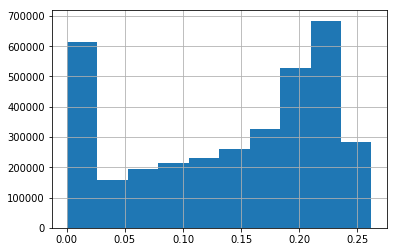

In [107]:
result['class_99'].hist()

In [108]:
del pred['hostgal_photoz']
result = pred.set_index('object_id')

In [109]:
result.to_csv('../output/predictions_1216_v5.csv', float_format='%.6f')

In [48]:
import os
os.chdir('/home/makoto.hyodo/')

In [49]:
%%bash
sh kaggle_submit_fix.sh PLAsTiCC output predictions_1216_v4.csv PLAsTiCC-2018 NN_model_oof

Successfully submitted to PLAsTiCC Astronomical Classification

: not found
100%|██████████| 480M/480M [00:22<00:00, 22.6MB/s]


In [50]:
os.chdir('/home/makoto.hyodo/kaggle/PLAsTiCC/script')

## modeling_lgbm

In [53]:
gc.collect()
y = train['target']
del train['target']
del train['object_id'], test['object_id']

In [54]:
import logging


def create_logger():
    logger_ = logging.getLogger('main')
    logger_.setLevel(logging.DEBUG)
    fh = logging.FileHandler('simple_lightgbm_v2.log')
    fh.setLevel(logging.DEBUG)
    ch = logging.StreamHandler()
    ch.setLevel(logging.DEBUG)
    formatter = logging.Formatter('[%(levelname)s]%(asctime)s:%(name)s:%(message)s')
    fh.setFormatter(formatter)
    ch.setFormatter(formatter)
    # add the handlers to the logger
    logger_.addHandler(fh)
    logger_.addHandler(ch)


def get_logger():
    return logging.getLogger('main')

In [55]:
from sklearn.model_selection import StratifiedKFold
def train_classifiers(full_train=None, y=None):

    folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    clfs = []
    importances = pd.DataFrame()
    # conclusion:defalut is great!
    lgb_params = {
        'boosting_type': 'gbdt',
        'objective': 'multiclass',
        'num_class': 14,
        'metric': 'multi_logloss',
        'learning_rate': 0.03, #def:0.03
        'subsample': .8,
        'colsample_bytree': .7,
        'reg_alpha': .01,
        'reg_lambda': .01,
        'min_split_gain': 0.01, #def:0.01
        'min_child_weight': 10, # def:10
        #'min_data_in_leaf':50,
        'n_estimators': 4000,
        'silent': -1,
        'verbose': -1,
        'max_depth': 3,
        #'num_leaves': 3, # add
        #'max_bin':31 #add
        #'use_missing': False
    }
    
    # Compute weights
    w = y.value_counts()
    weights = {i : np.sum(w) / w[i] for i in w.index}
        
    oof_preds = np.zeros((len(full_train), np.unique(y).shape[0]))
    for fold_, (trn_, val_) in enumerate(folds.split(y, y)):
        trn_x, trn_y = full_train.iloc[trn_], y.iloc[trn_]
        val_x, val_y = full_train.iloc[val_], y.iloc[val_]

        clf = lgb.LGBMClassifier(**lgb_params)
        clf.fit(
            trn_x, trn_y,
            eval_set=[(trn_x, trn_y), (val_x, val_y)],
            eval_metric=lgb_multi_weighted_logloss,
            verbose=100,
            early_stopping_rounds=50,
            sample_weight=trn_y.map(weights)
        )
        oof_preds[val_, :] = clf.predict_proba(val_x, num_iteration=clf.best_iteration_)
        get_logger().info(multi_weighted_logloss(val_y, clf.predict_proba(val_x, num_iteration=clf.best_iteration_)))

        imp_df = pd.DataFrame()
        imp_df['feature'] = full_train.columns
        imp_df['gain'] = clf.feature_importances_
        imp_df['fold'] = fold_ + 1
        importances = pd.concat([importances, imp_df], axis=0, sort=False)

        clfs.append(clf)

    get_logger().info('MULTI WEIGHTED LOG LOSS : %.5f ' % multi_weighted_logloss(y_true=y, y_preds=oof_preds))
    print('MULTI WEIGHTED LOG LOSS : %.5f ' % multi_weighted_logloss(y_true=y, y_preds=oof_preds))

    return clfs, importances, oof_preds


In [56]:
import matplotlib.pyplot as plt
import seaborn as sns
def save_importances(importances_):
    mean_gain = importances_[['gain', 'feature']].groupby('feature').mean()
    importances_['mean_gain'] = importances_['feature'].map(mean_gain['gain'])
    plt.figure(figsize=(8, 20))
    sns.barplot(x='gain', y='feature', data=importances_.sort_values('mean_gain', ascending=False))
    plt.tight_layout()
    plt.savefig('importances_1117_v1.png')

In [180]:
#importances[importances['feature']=='flux_max__sample_entropy']

In [181]:
#importances['feature'][importances['mean_gain'] < 108].tolist()

## select model feature

In [107]:
from sklearn.feature_selection import SelectFromModel
lgb_selector = SelectFromModel(clf)
lgb_selector.fit(train, y)

SelectFromModel(estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.7,
        importance_type='split', learning_rate=0.03, max_depth=3,
        metric='multi_logloss', min_child_samples=20, min_child_weight=10,
        min_split_gain=0.01, n_estimators=4000, n_jobs=-1, num_class=14,
        num_leaves=31, objective='multiclass', random_state=None,
        reg_alpha=0.01, reg_lambda=0.01, silent=-1, subsample=0.8,
        subsample_for_bin=200000, subsample_freq=0, verbose=-1),
        norm_order=1, prefit=False, threshold=None)

In [24]:
#lgb_support=lgb_selector.get_support()
#lgb_feature=train.loc[:,lgb_support].columns.tolist()
#lgb_feature

In [112]:
train_2 = train[lgb_feature]
test_2 = test[lgb_feature]

Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 0.555449	training's wloss: 0.544835	valid_1's multi_logloss: 0.853024	valid_1's wloss: 0.750352
[200]	training's multi_logloss: 0.379807	training's wloss: 0.368229	valid_1's multi_logloss: 0.721021	valid_1's wloss: 0.592964
[300]	training's multi_logloss: 0.309704	training's wloss: 0.298482	valid_1's multi_logloss: 0.684626	valid_1's wloss: 0.574896
Early stopping, best iteration is:
[313]	training's multi_logloss: 0.302562	training's wloss: 0.291375	valid_1's multi_logloss: 0.681426	valid_1's wloss: 0.574137
Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 0.558442	training's wloss: 0.547955	valid_1's multi_logloss: 0.858084	valid_1's wloss: 0.690874
[200]	training's multi_logloss: 0.382272	training's wloss: 0.371131	valid_1's multi_logloss: 0.72966	valid_1's wloss: 0.589401
Early stopping, best iteration is:
[217]	training's multi_logloss: 0.36695

/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


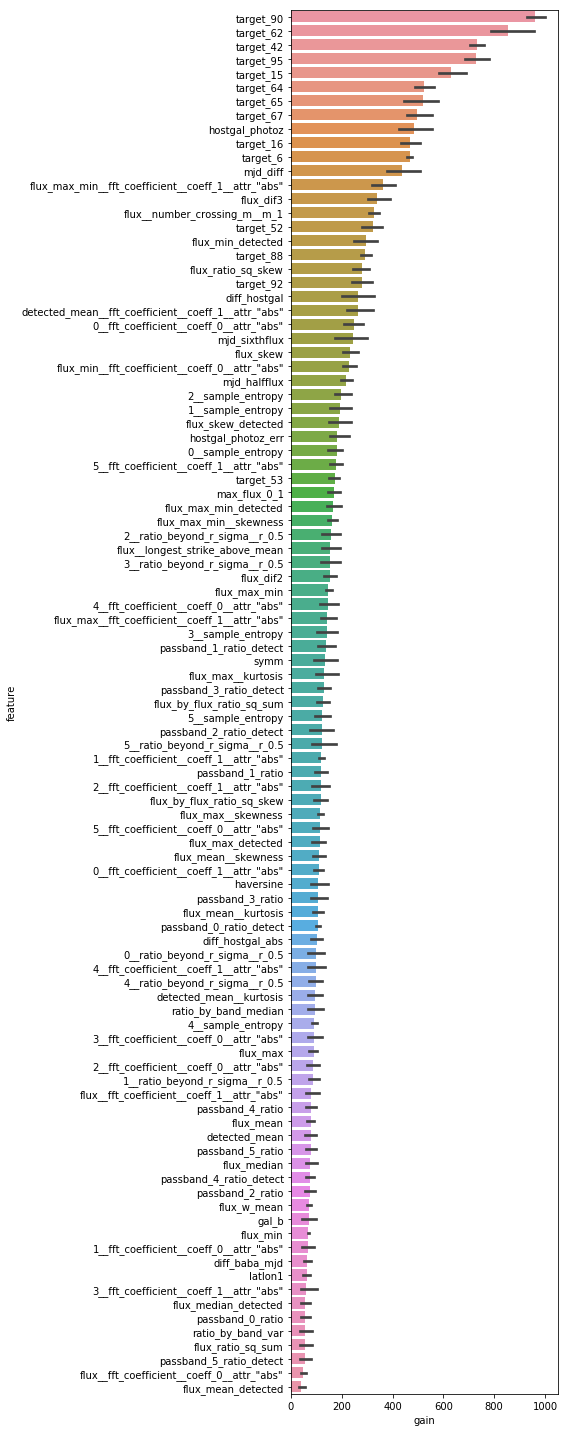

In [57]:
#add_oof_preds
clfs, importances, oof_preds = train_classifiers(train, y)
save_importances(importances_=importances)

Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 0.731925	training's wloss: 0.719485	valid_1's multi_logloss: 1.0922	valid_1's wloss: 0.872408
[200]	training's multi_logloss: 0.480552	training's wloss: 0.466971	valid_1's multi_logloss: 0.867805	valid_1's wloss: 0.676798
[300]	training's multi_logloss: 0.372587	training's wloss: 0.359299	valid_1's multi_logloss: 0.779515	valid_1's wloss: 0.623369
[400]	training's multi_logloss: 0.308924	training's wloss: 0.29595	valid_1's multi_logloss: 0.728689	valid_1's wloss: 0.598472
[500]	training's multi_logloss: 0.263155	training's wloss: 0.25079	valid_1's multi_logloss: 0.695812	valid_1's wloss: 0.593428
Early stopping, best iteration is:
[538]	training's multi_logloss: 0.249559	training's wloss: 0.23746	valid_1's multi_logloss: 0.685869	valid_1's wloss: 0.592103
Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 0.736687	training's wloss: 0.724856	valid_1's 

/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


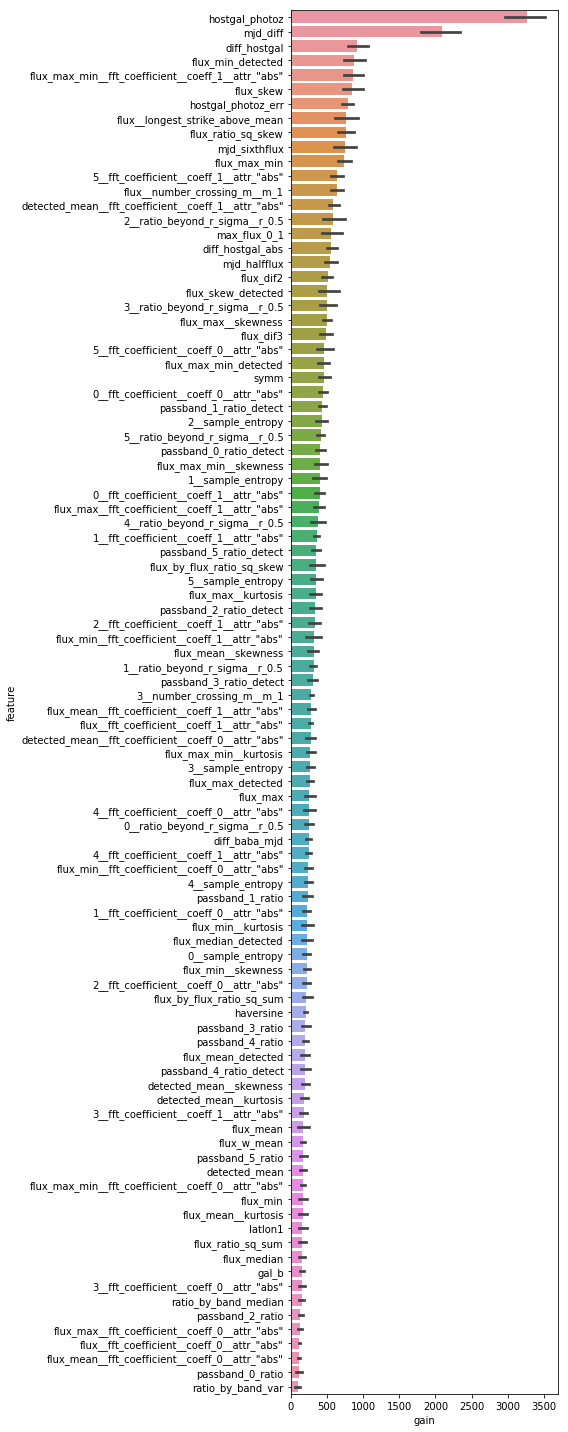

In [26]:
#add_only_importance_high and drop mjd
clfs, importances, oof_preds = train_classifiers(train, y)
save_importances(importances_=importances)

Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 0.731539	training's wloss: 0.719113	valid_1's multi_logloss: 1.09152	valid_1's wloss: 0.872599
[200]	training's multi_logloss: 0.482318	training's wloss: 0.468775	valid_1's multi_logloss: 0.866006	valid_1's wloss: 0.681084
[300]	training's multi_logloss: 0.375834	training's wloss: 0.362583	valid_1's multi_logloss: 0.779388	valid_1's wloss: 0.63316
[400]	training's multi_logloss: 0.311339	training's wloss: 0.298542	valid_1's multi_logloss: 0.728781	valid_1's wloss: 0.607329
[500]	training's multi_logloss: 0.265833	training's wloss: 0.253836	valid_1's multi_logloss: 0.698161	valid_1's wloss: 0.60007
[600]	training's multi_logloss: 0.231318	training's wloss: 0.220232	valid_1's multi_logloss: 0.675325	valid_1's wloss: 0.599167
Early stopping, best iteration is:
[586]	training's multi_logloss: 0.236201	training's wloss: 0.225001	valid_1's multi_logloss: 0.677912	valid_1's wloss: 0.597774
Training u

/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


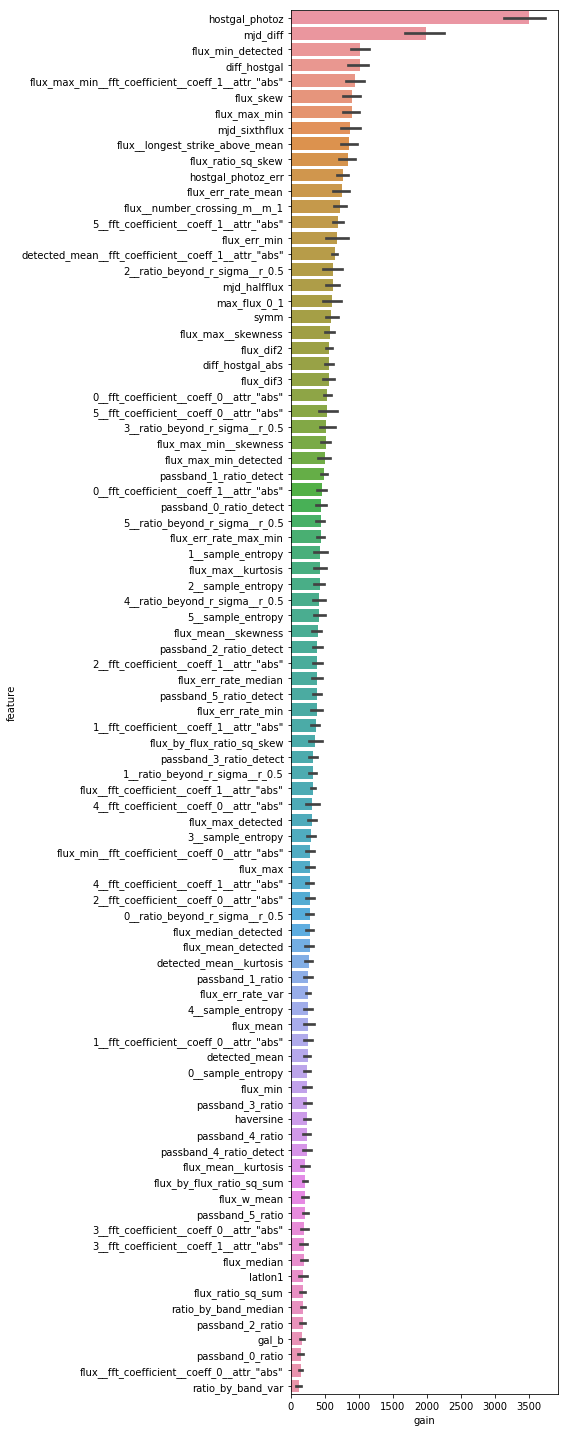

In [103]:
#add_only_importance_high and drop mjd
clfs, importances, oof_preds = train_classifiers(train, y)
save_importances(importances_=importances)

Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 0.732005	training's wloss: 0.71981	valid_1's multi_logloss: 1.09243	valid_1's wloss: 0.87377
[200]	training's multi_logloss: 0.481836	training's wloss: 0.467846	valid_1's multi_logloss: 0.866689	valid_1's wloss: 0.680013
[300]	training's multi_logloss: 0.374054	training's wloss: 0.360607	valid_1's multi_logloss: 0.778483	valid_1's wloss: 0.630789
[400]	training's multi_logloss: 0.309023	training's wloss: 0.295988	valid_1's multi_logloss: 0.727379	valid_1's wloss: 0.606069
[500]	training's multi_logloss: 0.263737	training's wloss: 0.25151	valid_1's multi_logloss: 0.696065	valid_1's wloss: 0.595728
[600]	training's multi_logloss: 0.229287	training's wloss: 0.218032	valid_1's multi_logloss: 0.672643	valid_1's wloss: 0.5918
Early stopping, best iteration is:
[630]	training's multi_logloss: 0.220374	training's wloss: 0.209483	valid_1's multi_logloss: 0.666829	valid_1's wloss: 0.590007
Training unti

/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


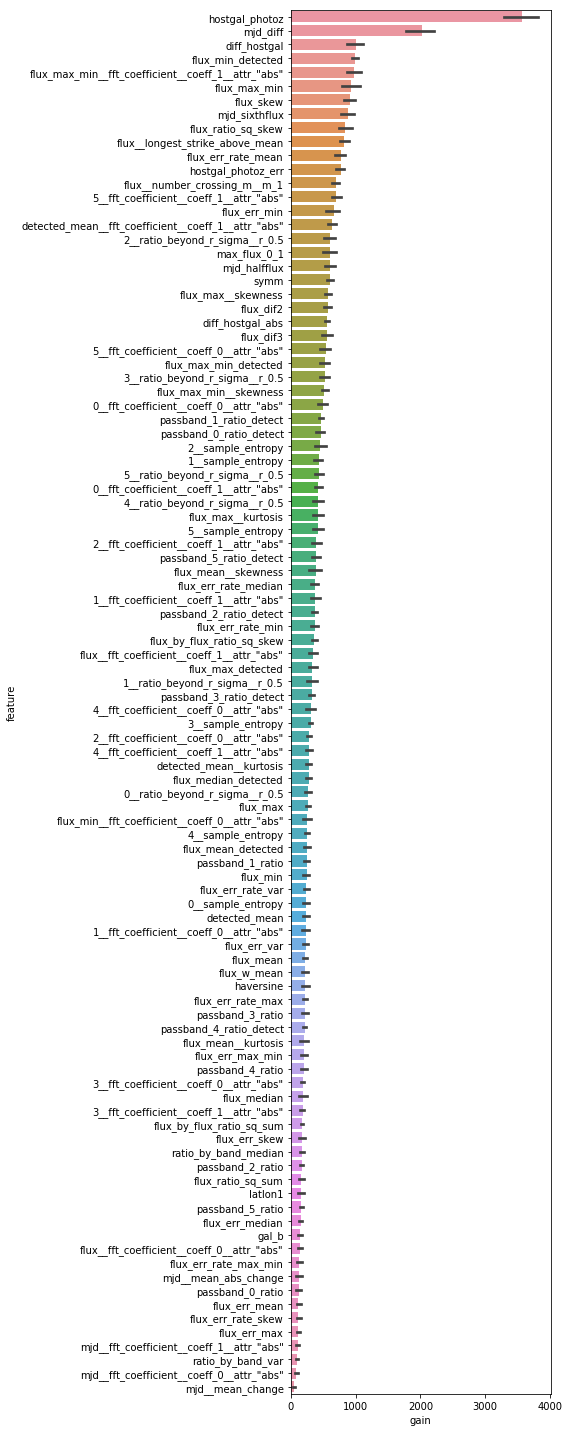

In [54]:
#add_error
clfs, importances, oof_preds = train_classifiers(train, y)
save_importances(importances_=importances)

In [ ]:
#add_mjd_diff
clfs, importances, oof_preds = train_classifiers(train, y)
save_importances(importances_=importances)

Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 0.735781	training's wloss: 0.722772	valid_1's multi_logloss: 1.09565	valid_1's wloss: 0.875369
[200]	training's multi_logloss: 0.484246	training's wloss: 0.470145	valid_1's multi_logloss: 0.870192	valid_1's wloss: 0.680051
[300]	training's multi_logloss: 0.377724	training's wloss: 0.363917	valid_1's multi_logloss: 0.781526	valid_1's wloss: 0.62391
[400]	training's multi_logloss: 0.313055	training's wloss: 0.299886	valid_1's multi_logloss: 0.730307	valid_1's wloss: 0.598297
[500]	training's multi_logloss: 0.267244	training's wloss: 0.254896	valid_1's multi_logloss: 0.697255	valid_1's wloss: 0.589905
Early stopping, best iteration is:
[520]	training's multi_logloss: 0.259347	training's wloss: 0.247201	valid_1's multi_logloss: 0.691963	valid_1's wloss: 0.589406
Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 0.738685	training's wloss: 0.725742	valid_1

Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 0.7377	training's wloss: 0.724787	valid_1's multi_logloss: 1.09671	valid_1's wloss: 0.875505
[200]	training's multi_logloss: 0.486759	training's wloss: 0.472877	valid_1's multi_logloss: 0.872777	valid_1's wloss: 0.680536
[300]	training's multi_logloss: 0.380059	training's wloss: 0.366432	valid_1's multi_logloss: 0.785373	valid_1's wloss: 0.62747
[400]	training's multi_logloss: 0.315217	training's wloss: 0.301987	valid_1's multi_logloss: 0.733723	valid_1's wloss: 0.601696
[500]	training's multi_logloss: 0.268777	training's wloss: 0.256308	valid_1's multi_logloss: 0.700981	valid_1's wloss: 0.593708
Early stopping, best iteration is:
[482]	training's multi_logloss: 0.276321	training's wloss: 0.263664	valid_1's multi_logloss: 0.705633	valid_1's wloss: 0.593197
Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 0.739843	training's wloss: 0.727555	valid_1's

/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


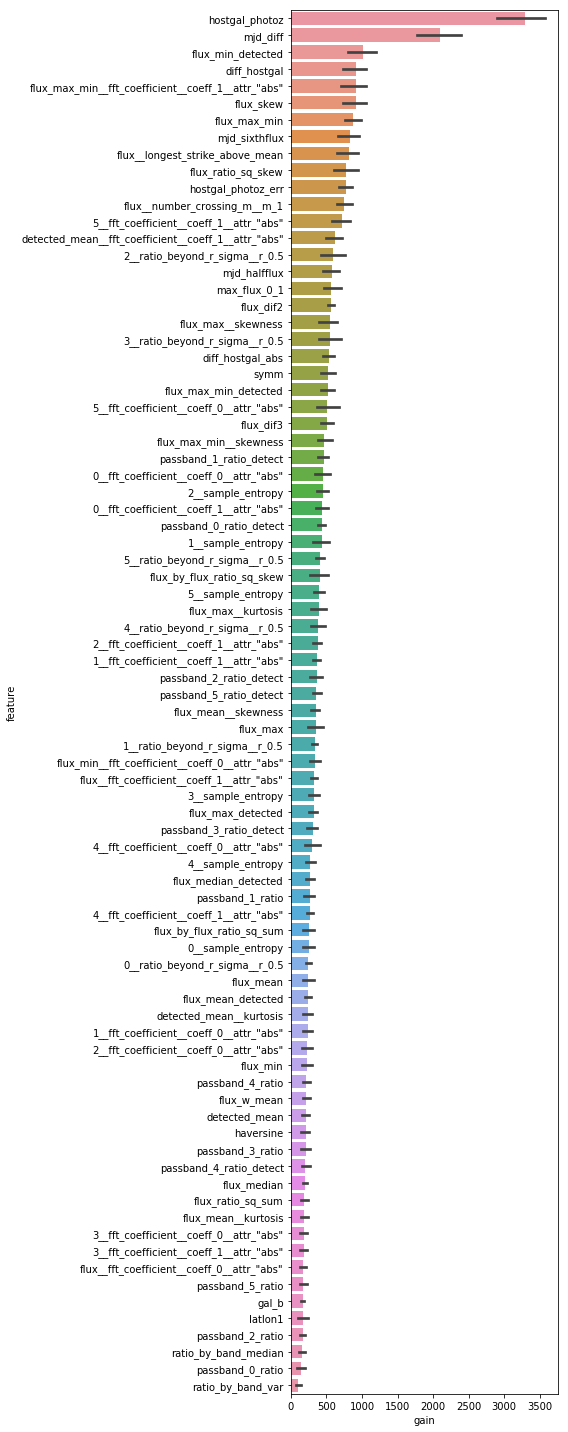

In [29]:
#add_helpful_val
clfs, importances, oof_preds = train_classifiers(train, y)
save_importances(importances_=importances)

/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Normalized confusion matrix


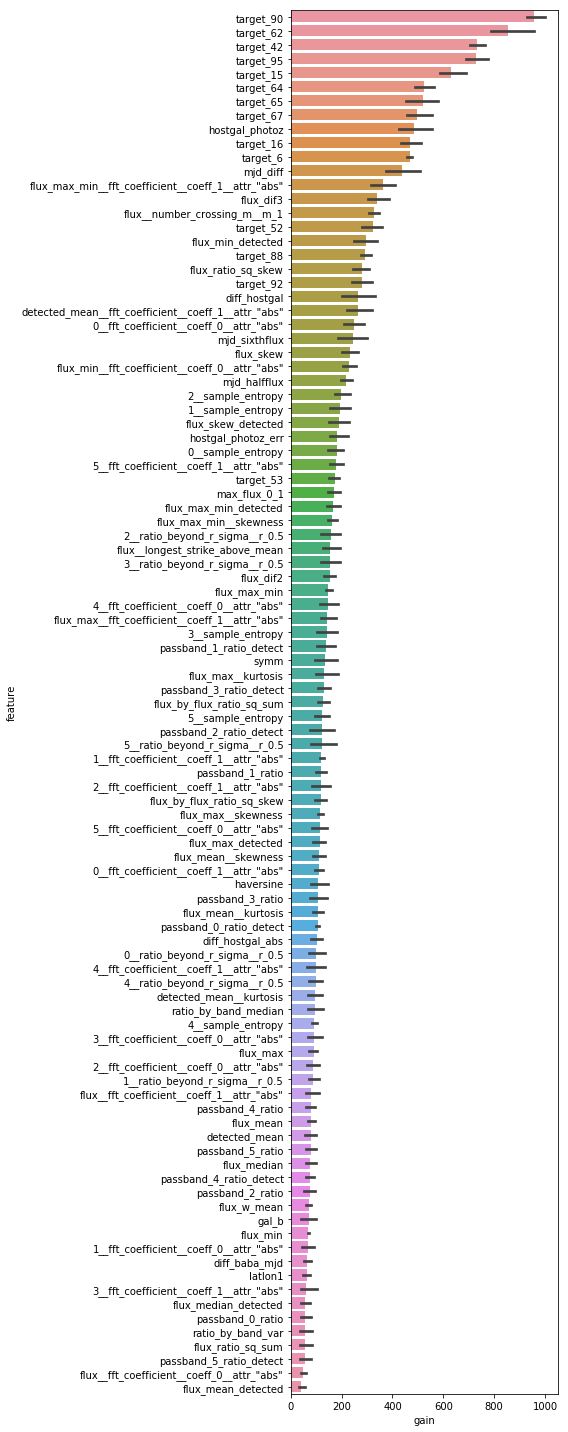

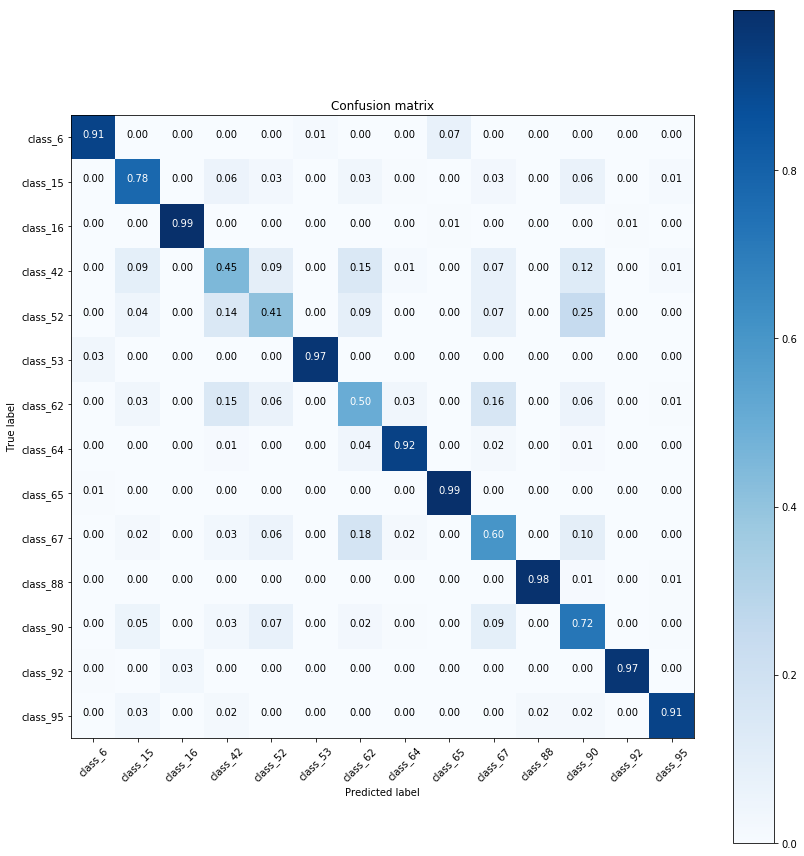

In [58]:
import itertools
save_importances(importances_=importances)
# http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
unique_y = np.unique(y)
class_map = dict()
for i,val in enumerate(unique_y):
    class_map[val] = i
        
y_map = np.zeros((y.shape[0],))
y_map = np.array([class_map[val] for val in y])

# Compute confusion matrix
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(y_map, np.argmax(oof_preds,axis=-1))
np.set_printoptions(precision=2)

sample_sub = pd.read_csv('../input/sample_submission.csv')
class_names = list(sample_sub.columns[1:-1])
del sample_sub;gc.collect()

# Plot non-normalized confusion matrix
plt.figure(figsize=(12,12))
foo = plot_confusion_matrix(cnf_matrix, classes=class_names,normalize=True,
                      title='Confusion matrix')

/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Normalized confusion matrix


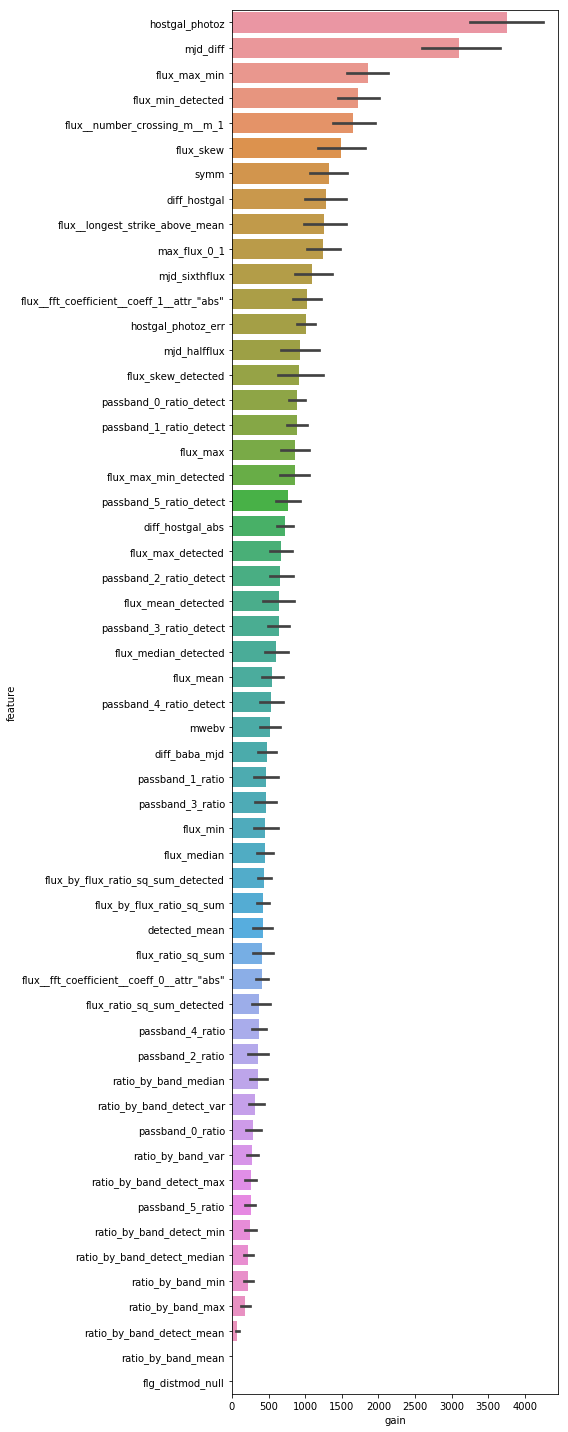

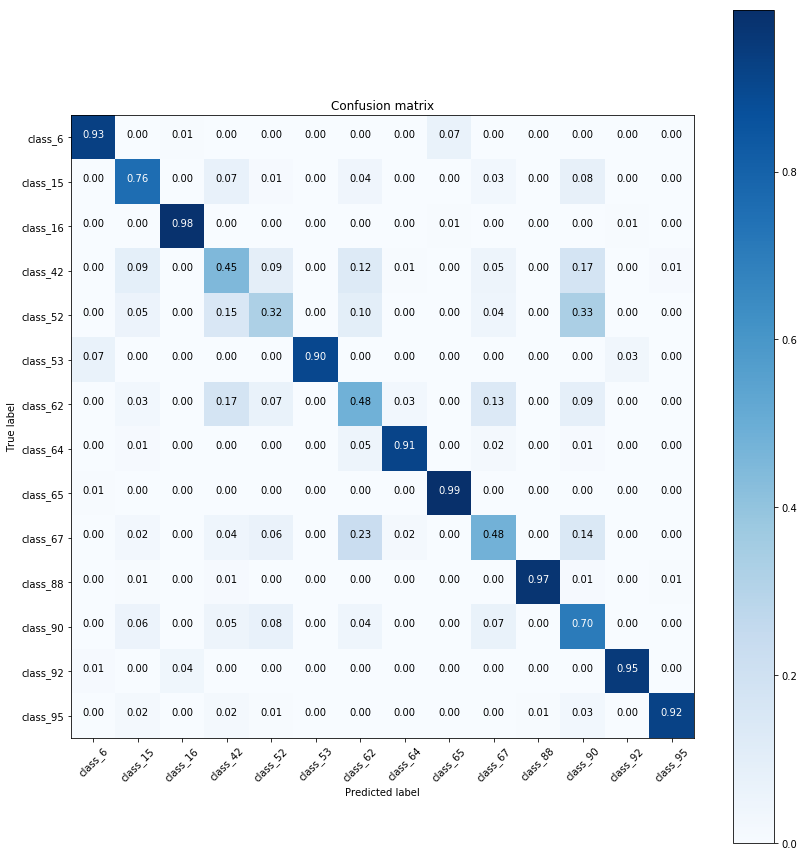

In [184]:
import itertools
save_importances(importances_=importances)
# http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
unique_y = np.unique(y)
class_map = dict()
for i,val in enumerate(unique_y):
    class_map[val] = i
        
y_map = np.zeros((y.shape[0],))
y_map = np.array([class_map[val] for val in y])

# Compute confusion matrix
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(y_map, np.argmax(oof_preds,axis=-1))
np.set_printoptions(precision=2)

sample_sub = pd.read_csv('../input/sample_submission.csv')
class_names = list(sample_sub.columns[1:-1])
del sample_sub;gc.collect()

# Plot non-normalized confusion matrix
plt.figure(figsize=(12,12))
foo = plot_confusion_matrix(cnf_matrix, classes=class_names,normalize=True,
                      title='Confusion matrix')

In [59]:
from tqdm import tqdm_notebook

preds_ = None
for clf in tqdm_notebook(clfs):
    if preds_ is None:
        preds_ = clf.predict_proba(test) / len(clfs)
    else:
        preds_ += clf.predict_proba(test) / len(clfs)

In [60]:
test = pd.read_pickle('../input/test_meta_add_feature.pickle')

In [61]:
preds_99 = np.ones(preds_.shape[0])
for i in range(preds_.shape[1]):
    preds_99 *= (1 - preds_[:, i])

# Create DataFrame from predictions
preds_df_ = pd.DataFrame(preds_, columns=['class_' + str(s) for s in clfs[0].classes_])
preds_df_['object_id'] = test['object_id']
preds_df_['class_99'] = 0.14 * preds_99 / np.mean(preds_99) 

In [62]:
preds_df_.head(5)

,class_6,class_15,class_16,class_42,class_52,class_53,class_62,class_64,class_65,class_67,class_88,class_90,class_92,class_95,object_id,class_99
0,0.001420,0.003634,0.001432,0.267656,0.639623,0.001422,0.041832,0.001401,0.001427,0.003826,0.001512,0.031218,0.001432,0.002165,13,0.131901
1,0.002159,0.019795,0.002049,0.133537,0.135217,0.002027,0.118710,0.002406,0.002081,0.084699,0.011960,0.472207,0.002104,0.011051,14,0.165636
2,0.001363,0.016001,0.001477,0.066475,0.111500,0.001359,0.034046,0.001706,0.001363,0.019853,0.020634,0.717788,0.001369,0.005068,17,0.115677
3,0.002113,0.005065,0.001887,0.076337,0.099239,0.001868,0.049635,0.003013,0.001877,0.126172,0.010329,0.605433,0.001882,0.015149,23,0.143345
4,0.000861,0.002239,0.000863,0.032074,0.066261,0.000857,0.024525,0.000948,0.000860,0.006112,0.000870,0.861538,0.000864,0.001129,34,0.065992


In [29]:
preds_df_.head(5)

,class_6,class_15,class_16,class_42,class_52,class_53,class_62,class_64,class_65,class_67,class_88,class_90,class_92,class_95,object_id,class_99
0,0.000062,0.001267,0.000070,0.349904,0.375338,0.000003,0.062816,0.000015,0.000012,0.001996,0.000075,0.206431,0.000011,0.001999,13,0.159581
1,0.000018,0.007057,0.000068,0.210652,0.100615,0.000004,0.109492,0.000070,0.000572,0.054347,0.001759,0.510194,0.000018,0.005136,14,0.153303
2,0.000013,0.016947,0.000069,0.076209,0.077356,0.000003,0.044599,0.001979,0.000286,0.173947,0.018005,0.583413,0.000015,0.007159,17,0.142361
3,0.000042,0.001053,0.000045,0.073658,0.079171,0.000003,0.059530,0.009028,0.000258,0.246459,0.001703,0.522114,0.000003,0.006934,23,0.150578
4,0.000032,0.005122,0.000030,0.099782,0.177621,0.000003,0.035621,0.000033,0.000043,0.011427,0.000004,0.668928,0.000003,0.001351,34,0.123328


In [63]:
result = preds_df_.set_index('object_id')

In [64]:
result.to_csv('../output/predictions_1123_v5.csv', float_format='%.6f')

In [65]:
import os
os.chdir('/home/makoto.hyodo/')

In [66]:
%%bash
sh kaggle_submit_fix.sh PLAsTiCC output predictions_1123_v5.csv PLAsTiCC-2018 add_oofpred

Successfully submitted to PLAsTiCC Astronomical Classification

: not found
100%|██████████| 480M/480M [00:23<00:00, 21.8MB/s]


In [67]:
os.chdir('/home/makoto.hyodo/kaggle/PLAsTiCC/script')

## post_process

### とりあえずdiscussionに従って以下のように定める
#### Galactic and ExtraGalactic 0.017 and 0.17

In [236]:
test = pd.read_pickle('../input/test_meta_add_feature.pickle')

In [237]:
def func_class99(x):
    if x.hostgal_photoz==0: 
        return 0.017
    else: 
        return 0.17

In [238]:
test_weight = test[['object_id','hostgal_photoz']]
test_weight['class_99'] = test_weight.apply(lambda x : func_class99(x),axis=1)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [420]:
res['pred_labels'] = pd.merge(res['pred_labels'],test_weight['class_99'].to_frame(),right_index = True,left_index = True)
res['pred_labels'].head(3)

,class_15,class_16,class_42,class_52,class_53,class_6,class_62,class_64,class_65,class_67,class_88,class_90,class_92,class_95,class_99
0,0.000069,0.000172,0.254196,0.288599,0.000342,0.000290,0.014052,0.000056,0.000045,0.016772,0.000285,0.424572,0.000096,0.000455,0.17
1,0.005612,0.001012,0.013487,0.003013,0.000325,0.000308,0.008169,0.000545,0.003810,0.003736,0.016758,0.941978,0.000096,0.001151,0.17
2,0.006349,0.001036,0.006003,0.001952,0.000306,0.000256,0.003398,0.000263,0.002590,0.004005,0.157703,0.814195,0.000105,0.001840,0.17


In [294]:
res['pred_labels'] = pd.merge(res['pred_labels'],test_weight['class_99'].to_frame(),right_index = True,left_index = True)
res['pred_labels'].head(3)

,class_15,class_16,class_42,class_52,class_53,class_6,class_62,class_64,class_65,class_67,class_88,class_90,class_92,class_95,class_99
0,0.000087,0.000200,0.156841,0.209067,0.000413,0.000329,0.019714,0.000039,0.000063,0.032214,0.000350,0.580351,0.000138,0.000195,0.17
1,0.004788,0.000605,0.023982,0.002056,0.000222,0.000112,0.006217,0.000268,0.001017,0.003073,0.015631,0.941576,0.000036,0.000417,0.17
2,0.004330,0.000586,0.022255,0.001218,0.000197,0.000102,0.002576,0.000103,0.000636,0.005444,0.153861,0.807615,0.000032,0.001047,0.17


In [239]:
res['pred_labels'] = pd.merge(res['pred_labels'],test_weight['class_99'].to_frame(),right_index = True,left_index = True)
res['pred_labels'].head(3)

,class_15,class_16,class_42,class_52,class_53,class_6,class_62,class_64,class_65,class_67,class_88,class_90,class_92,class_95,class_99
0,0.000170,0.000129,0.219734,0.207696,0.000393,0.000301,0.030571,0.00003,0.000042,0.027114,0.000506,0.512642,0.000131,0.000541,0.17
1,0.010315,0.002170,0.034871,0.003626,0.000649,0.000477,0.019398,0.00066,0.006094,0.012193,0.057752,0.850466,0.000094,0.001235,0.17
2,0.006608,0.000757,0.010054,0.001699,0.000237,0.000143,0.002663,0.00014,0.001621,0.006476,0.236238,0.732116,0.000034,0.001214,0.17


In [187]:
res['pred_labels'] = pd.merge(res['pred_labels'],test_weight['class_99'].to_frame(),right_index = True,left_index = True)
res['pred_labels'].head(3)

,class_15,class_16,class_42,class_52,class_53,class_6,class_62,class_64,class_65,class_67,class_88,class_90,class_92,class_95,class_99
0,0.000112,0.000090,0.181537,0.299787,0.000251,0.000158,0.021210,0.000029,0.000039,0.045279,0.000251,0.450810,0.000079,0.000369,0.17
1,0.001969,0.001235,0.010492,0.003910,0.000227,0.000087,0.008925,0.000269,0.001665,0.002882,0.024138,0.943210,0.000034,0.000958,0.17
2,0.003141,0.000826,0.010449,0.001058,0.000168,0.000101,0.002377,0.000057,0.000693,0.005202,0.172511,0.802539,0.000030,0.000850,0.17


In [131]:
res['pred_labels'] = pd.merge(res['pred_labels'],test_weight['class_99'].to_frame(),right_index = True,left_index = True)
res['pred_labels'].head(3)

,class_15,class_16,class_42,class_52,class_53,class_6,class_62,class_64,class_65,class_67,class_88,class_90,class_92,class_95,class_99
0,0.005846,0.034730,0.002683,0.007164,0.001308,0.001576,0.003106,0.006597,0.019561,0.001544,0.889478,0.010497,0.007301,0.00861,0.17
1,0.006481,0.025522,0.003074,0.006624,0.001308,0.001217,0.003076,0.006596,0.030239,0.001579,0.889459,0.011902,0.004311,0.00861,0.17
2,0.080886,0.019182,0.004073,0.003979,0.001182,0.001187,0.001670,0.005160,0.045811,0.000571,0.800544,0.008546,0.004909,0.02230,0.17


In [421]:
for i in range(0,14):
    res['pred_labels'].iloc[:,i] = res['pred_labels'].iloc[:,i] * (1 - res['pred_labels']['class_99'])
#test_labels['class_15'] = test_labels['class_15'] * (1 - test_labels['class_99'])

In [422]:
res['pred_labels'].sum(axis=1).head(3)

0    1.0
1    1.0
2    1.0
dtype: float64

## submit

In [423]:
sub = pd.read_csv('../input/sample_submission.csv')
sub = sub.set_index('object_id')
sub[:] = 0
sub.head()

,class_6,class_15,class_16,class_42,class_52,class_53,class_62,class_64,class_65,class_67,class_88,class_90,class_92,class_95,class_99
object_id,,,,,,,,,,,,,,,
13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
34,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [424]:
classnames = sub.columns.tolist()
print(sub.shape, classnames)

(3492890, 15) ['class_6', 'class_15', 'class_16', 'class_42', 'class_52', 'class_53', 'class_62', 'class_64', 'class_65', 'class_67', 'class_88', 'class_90', 'class_92', 'class_95', 'class_99']


In [425]:
for c in res['pred_labels'].columns:
    sub.loc[:,c] = res['pred_labels'][c].values

In [426]:
sub.head(10)

,class_6,class_15,class_16,class_42,class_52,class_53,class_62,class_64,class_65,class_67,class_88,class_90,class_92,class_95,class_99
object_id,,,,,,,,,,,,,,,
13,0.000241,0.000057,0.000143,0.210983,0.239537,0.000284,0.011663,0.000047,0.000037,0.013920,0.000236,0.352395,0.000080,0.000378,0.17
14,0.000256,0.004658,0.000840,0.011194,0.002500,0.000270,0.006780,0.000453,0.003162,0.003101,0.013909,0.781842,0.000080,0.000956,0.17
17,0.000213,0.005269,0.000860,0.004983,0.001620,0.000254,0.002820,0.000218,0.002150,0.003324,0.130893,0.675781,0.000087,0.001527,0.17
23,0.000228,0.000141,0.000305,0.005507,0.002246,0.000151,0.001522,0.000287,0.001261,0.005142,0.002068,0.810116,0.000033,0.000994,0.17
34,0.000077,0.000300,0.000023,0.024999,0.009027,0.000130,0.003134,0.000013,0.000276,0.000677,0.000117,0.791044,0.000077,0.000107,0.17
35,0.000285,0.000129,0.000117,0.007269,0.001549,0.000177,0.001230,0.000052,0.000132,0.002798,0.000573,0.813766,0.000050,0.001873,0.17
43,0.000196,0.000192,0.000700,0.002595,0.003342,0.000211,0.009869,0.000444,0.002450,0.002993,0.005735,0.800275,0.000048,0.000947,0.17
50,0.000652,0.001264,0.002220,0.014498,0.003684,0.000764,0.049323,0.002505,0.012685,0.015660,0.062422,0.479342,0.000199,0.184781,0.17
60,0.001931,0.001011,0.001223,0.112371,0.013824,0.001197,0.040897,0.000378,0.003087,0.013159,0.003952,0.494946,0.000288,0.141735,0.17


In [427]:
os.chdir('/home/makoto.hyodo/kaggle/PLAsTiCC/script')
sub.to_csv('../output/submit_20181111_v5.csv')

In [428]:
import os
os.chdir('/home/makoto.hyodo/')

In [429]:
%%bash
sh kaggle_submit_fix.sh PLAsTiCC output submit_20181111_v5.csv PLAsTiCC-2018 add_feature_cv_0.7174

Successfully submitted to PLAsTiCC Astronomical Classification

: not found
100%|██████████| 1.02G/1.02G [00:47<00:00, 22.8MB/s]


In [430]:
os.chdir('/home/makoto.hyodo/kaggle/PLAsTiCC/script')